(sec-dataset-examples)=
# Quantify dataset - examples

```{seealso}
The complete source code of this tutorial can be found in

{nb-download}`Quantify dataset - examples.ipynb`
```

In [1]:
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
from rich import pretty

import quantify_core.data.dataset_attrs as dattrs
from quantify_core.analysis.calibration import rotate_to_calibrated_axis
from quantify_core.analysis.fitting_models import exp_decay_func
from quantify_core.data import handling as dh
from quantify_core.utilities import dataset_examples
from quantify_core.utilities.examples_support import (
    mk_iq_shots,
    mk_trace_for_iq_shot,
    mk_trace_time,
    round_trip_dataset,
)
from quantify_core.utilities.inspect_utils import display_source_code
from quantify_core.visualization.mpl_plotting import (
    plot_complex_points,
    plot_xr_complex,
    plot_xr_complex_on_plane,
)

pretty.install()

dh.set_datadir(Path.home() / "quantify-data")  # change me!

In this page we explore a series of datasets that comply with the {ref}`Quantify dataset specification <dataset-spec>`.

## 2D dataset example

We use the {func}`~quantify_core.utilities.dataset_examples.mk_two_qubit_chevron_dataset`
to generate our exemplary dataset. Its source code is conveniently displayed in the
drop-down below.

In [2]:
display_source_code(dataset_examples.mk_two_qubit_chevron_dataset)

def mk_two_qubit_chevron_dataset(**kwargs) -> xr.Dataset:
    """
    Generates a dataset that look similar to a two-qubit Chevron experiment.

    Parameters
    ----------
    **kwargs
        Keyword arguments passed to :func:`~.mk_two_qubit_chevron_data`.

    Returns
    -------
    :
        A mock Quantify dataset.
    """
    amp_values, time_values, pop_q0, pop_q1 = mk_two_qubit_chevron_data(**kwargs)

    dims_q0 = dims_q1 = ("repetitions", "main_dim")
    pop_q0_attrs = mk_main_var_attrs(
        long_name="Population Q0", unit="", has_repetitions=True
    )
    pop_q1_attrs = mk_main_var_attrs(
        long_name="Population Q1", unit="", has_repetitions=True
    )
    data_vars = dict(
        pop_q0=(dims_q0, pop_q0, pop_q0_attrs),
        pop_q1=(dims_q1, pop_q1, pop_q1_attrs),
    )

    dims_amp = dims_time = ("main_dim",)
    amp_attrs = mk_main_coord_attrs(long_name="Amplitude", unit="V")
    time_attrs = mk_main_coord_attrs(long_name="Time", unit="s")
    coords = dict(
        amp=(dims_amp, amp_values, amp_attrs),
        time=(dims_time, time_values, time_attrs),
    )

    dataset_attrs = mk_dataset_attrs()
    dataset = xr.Dataset(data_vars=data_vars, coords=coords, attrs=dataset_attrs)

    return dataset

In [3]:
dataset = dataset_examples.mk_two_qubit_chevron_dataset()

assert dataset == round_trip_dataset(dataset)  # confirm read/write
dataset

<xarray.Dataset> Size: 115kB
Dimensions:  (repetitions: 5, main_dim: 1200)
Coordinates:
    amp      (main_dim) float64 10kB 0.45 0.4534 0.4569 ... 0.5431 0.5466 0.55
    time     (main_dim) float64 10kB 0.0 0.0 0.0 0.0 ... 1e-07 1e-07 1e-07 1e-07
Dimensions without coordinates: repetitions, main_dim
Data variables:
    pop_q0   (repetitions, main_dim) float64 48kB 0.5 0.5 0.5 ... 0.4818 0.5
    pop_q1   (repetitions, main_dim) float64 48kB 0.5 0.5 0.5 ... 0.5371 0.5
Attributes:
    tuid:                      20241014-175523-232-a23ada
    dataset_name:              
    dataset_state:             None
    timestamp_start:           None
    timestamp_end:             None
    quantify_dataset_version:  2.0.0
    software_versions:         {}
    relationships:             []
    json_serialize_exclude:    []

The data within this dataset can be easily visualized using xarray facilities,
however, we first need to convert the Quantify dataset to a "gridded" version with the {func}`~quantify_core.data.handling.to_gridded_dataset` function as 
shown below.

Since our dataset contains multiple repetitions of the same experiment, it is convenient
to visualize them on different plots.

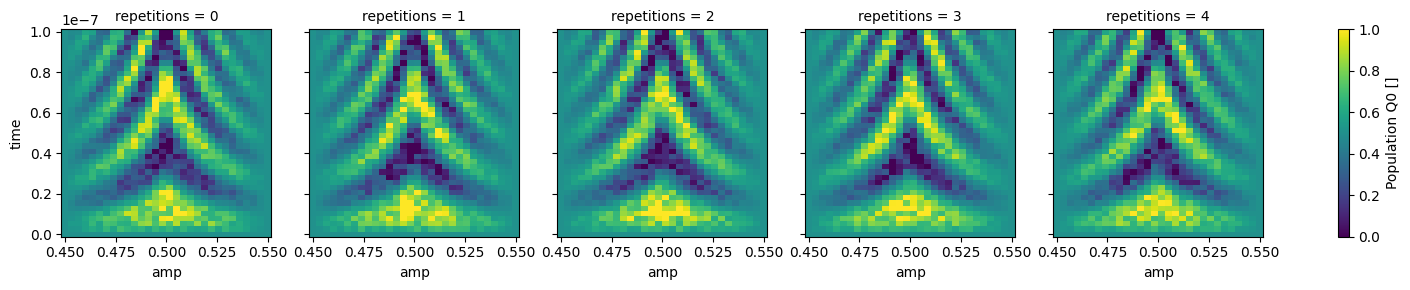

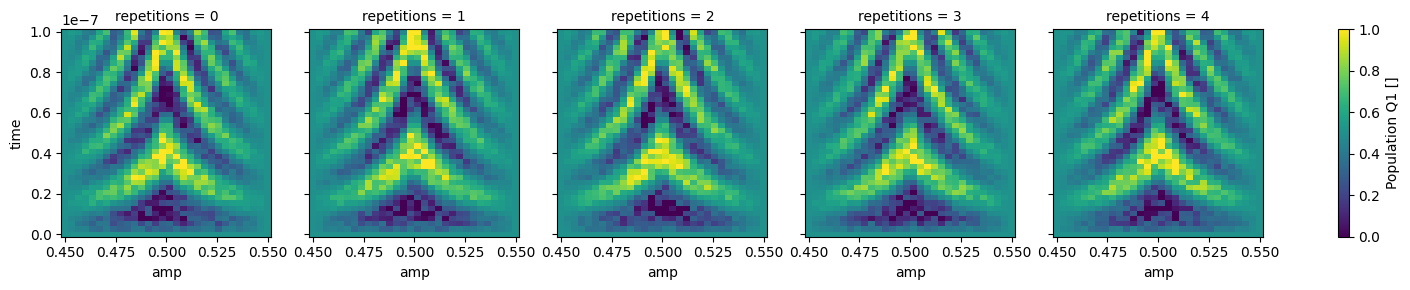

In [4]:
dataset_gridded = dh.to_gridded_dataset(
    dataset,
    dimension="main_dim",
    coords_names=dattrs.get_main_coords(dataset),
)
dataset_gridded.pop_q0.plot.pcolormesh(x="amp", col="repetitions")
_ = dataset_gridded.pop_q1.plot.pcolormesh(x="amp", col="repetitions")

In xarray, among other features, it is possible to average along a dimension which can
be very convenient to average out some of the noise:

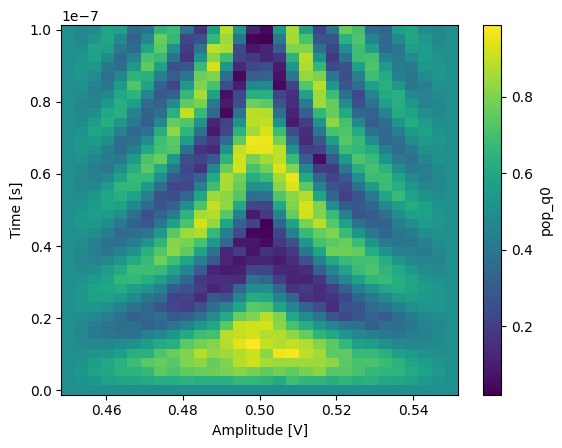

In [5]:
_ = dataset_gridded.pop_q0.mean(dim="repetitions").plot(x="amp")

A repetitions dimension can be indexed by a coordinate such that we can have some
specific label for each of our repetitions. To showcase this, we will modify the previous
dataset by merging it with a dataset containing the relevant extra information.

In [6]:
coord_dims = ("repetitions",)
coord_values = ["A", "B", "C", "D", "E"]
dataset_indexed_rep = xr.Dataset(coords=dict(repetitions=(coord_dims, coord_values)))

dataset_indexed_rep

<xarray.Dataset> Size: 20B
Dimensions:      (repetitions: 5)
Coordinates:
  * repetitions  (repetitions) <U1 20B 'A' 'B' 'C' 'D' 'E'
Data variables:
    *empty*

In [7]:
# merge with the previous dataset
dataset_rep = dataset_gridded.merge(dataset_indexed_rep, combine_attrs="drop_conflicts")

assert dataset_rep == round_trip_dataset(dataset_rep)  # confirm read/write

dataset_rep

<xarray.Dataset> Size: 97kB
Dimensions:      (amp: 30, time: 40, repetitions: 5)
Coordinates:
  * amp          (amp) float64 240B 0.45 0.4534 0.4569 ... 0.5431 0.5466 0.55
  * time         (time) float64 320B 0.0 2.564e-09 5.128e-09 ... 9.744e-08 1e-07
  * repetitions  (repetitions) <U1 20B 'A' 'B' 'C' 'D' 'E'
Data variables:
    pop_q0       (repetitions, amp, time) float64 48kB 0.5 0.5 0.5 ... 0.5 0.5
    pop_q1       (repetitions, amp, time) float64 48kB 0.5 0.5 0.5 ... 0.5 0.5
Attributes:
    tuid:                      20241014-175523-232-a23ada
    dataset_name:              
    dataset_state:             None
    timestamp_start:           None
    timestamp_end:             None
    quantify_dataset_version:  2.0.0
    software_versions:         {}
    relationships:             []
    json_serialize_exclude:    []

Now we can select a specific repetition by its coordinate, in this case a string label.

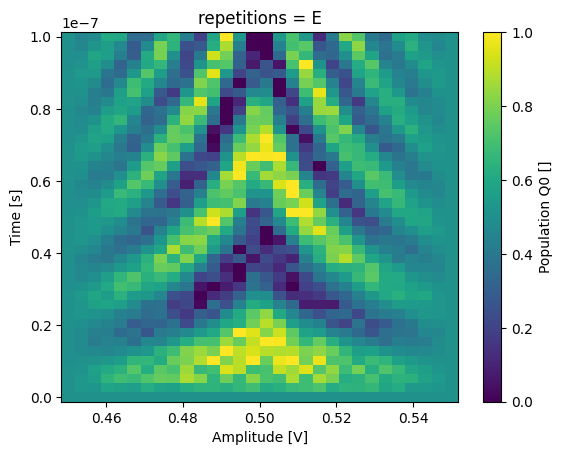

In [8]:
_ = dataset_rep.pop_q0.sel(repetitions="E").plot(x="amp")

## T1 dataset examples

The T1 experiment is one of the most common quantum computing experiments.
Here we explore how the datasets for such an experiment, for a transmon qubit, can be
stored using the Quantify dataset with increasing levels of data detail.

We start with the most simple format that contains only processed (averaged) measurements
and finish with a dataset containing the raw digitized signals from the transmon readout
during a T1 experiment.

We use a few auxiliary functions to generate, manipulate and plot the data of the
examples that follow:

- {func}`quantify_core.utilities.examples_support.mk_iq_shots`
- {func}`quantify_core.utilities.examples_support.mk_trace_time`
- {func}`quantify_core.utilities.examples_support.mk_trace_for_iq_shot`
- {func}`quantify_core.analysis.fitting_models.exp_decay_func`

Below you can find the source-code of the most important ones and a few usage
examples in order to gain some intuition for the mock data.

In [9]:
for func in (mk_iq_shots, mk_trace_time, mk_trace_for_iq_shot):
    display_source_code(func)

def mk_iq_shots(
    num_shots: int = 128,
    sigmas: Union[Tuple[float], NDArray[np.float64]] = (0.1, 0.1),
    centers: Union[Tuple[complex], NDArray[np.complex128]] = (-0.2 + 0.65j, 0.7 + 4j),
    probabilities: Union[Tuple[float], NDArray[np.float64]] = (0.4, 0.6),
    seed: Union[int, None] = 112233,
) -> NDArray:
    """
    Generate clusters of (I + 1j*Q) points with a Gaussian distribution.

    Utility to mock the data coming from qubit readout experiments.
    Clusters are centered around ``centers`` and data points are distributed between
    them according to ``probabilities``.

    .. seealso:: :ref:`howto-utilities-examples-ssro`

    Parameters
    ----------
    num_shots
        The number of shot to generate.
    sigma
        The sigma of the Gaussian distribution used for both real and imaginary parts.
    centers
        The center of each cluster on the imaginary plane.
    probabilities
        The probabilities of each cluster being randomly selected for each shot.
    seed
        Random number generator seed passed to ``numpy.random.default_rng``.
    """
    if not len(sigmas) == len(centers) == len(probabilities):
        raise ValueError(
            f"Incorrect input. sigmas={sigmas}, centers={centers} and "
            f"probabilities={probabilities} must have the same length."
        )

    rng = np.random.default_rng(seed=seed)

    cluster_indices = tuple(range(len(centers)))
    choices = rng.choice(a=cluster_indices, size=num_shots, p=probabilities)

    shots = []
    for idx in cluster_indices:
        num_shots_this_cluster = np.sum(choices == idx)
        i_data = rng.normal(
            loc=centers[idx].real,
            scale=sigmas[idx],
            size=num_shots_this_cluster,
        )
        q_data = rng.normal(
            loc=centers[idx].imag,
            scale=sigmas[idx],
            size=num_shots_this_cluster,
        )
        shots.append(i_data + 1j * q_data)
    return np.concatenate(shots)

def mk_trace_time(sampling_rate: float = 1e9, duration: float = 0.3e-6) -> NDArray:
    """
    Generates a :obj:`~numpy.arange` in which the entries correspond to time instants
    up to ``duration`` seconds sampled according to ``sampling_rate`` in Hz.

    See :func:`~.mk_trace_for_iq_shot` for an usage example.

    Parameters
    ----------
    sampling_rate
        The sampling rate in Hz.
    duration
        Total duration in seconds.

    Returns
    -------
    :
        An array with the time instants.
    """
    trace_length = sampling_rate * duration
    return np.arange(0, trace_length, 1) / sampling_rate

def mk_trace_for_iq_shot(
    iq_point: complex,
    time_values: Optional[NDArray] = None,
    intermediate_freq: float = 50e6,
) -> NDArray:
    """
    Generates mock "traces" that a physical instrument would digitize for the readout of
    a transmon qubit when using a down-converting IQ mixer.

    .. seealso:: :ref:`howto-utilities-examples-trace`

    Parameters
    ----------
    iq_point
        A complex number representing a point on the IQ-plane.
    time_values
        The time instants at which the mock intermediate-frequency signal is sampled.
    intermediate_freq
        The intermediate frequency used in the down-conversion scheme.

    Returns
    -------
    :
        An array of complex numbers.
    """  # pylint: disable=line-too-long
    if time_values is None:
        time_values = mk_trace_time()
    return iq_point * np.exp(2.0j * np.pi * intermediate_freq * time_values)

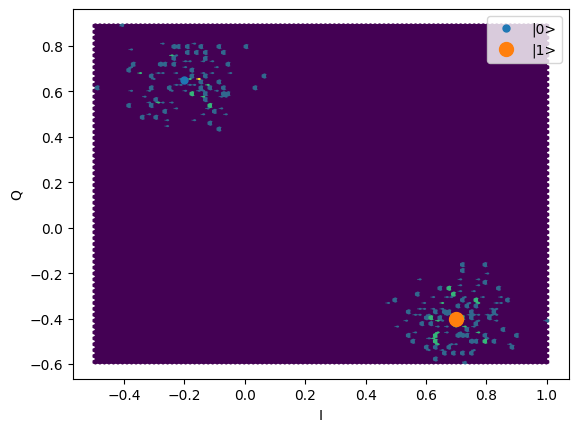

In [10]:
ground = -0.2 + 0.65j
excited = 0.7 - 0.4j
centers = ground, excited
sigmas = [0.1] * 2

shots = mk_iq_shots(
    num_shots=256,
    sigmas=sigmas,
    centers=centers,
    probabilities=[0.4, 1 - 0.4],
)

plt.hexbin(shots.real, shots.imag)
plt.xlabel("I")
plt.ylabel("Q")
_ = plot_complex_points(centers, ax=plt.gca())

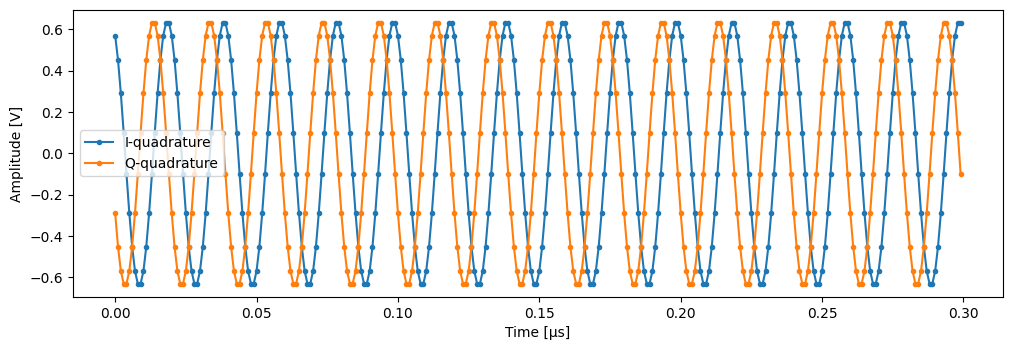

In [11]:
time = mk_trace_time()
trace = mk_trace_for_iq_shot(shots[0])

fig, ax = plt.subplots(1, 1, figsize=(12, 12 / 1.61 / 2))
ax.plot(time * 1e6, trace.imag, ".-", label="I-quadrature")
ax.plot(time * 1e6, trace.real, ".-", label="Q-quadrature")
ax.set_xlabel("Time [µs]")
ax.set_ylabel("Amplitude [V]")
_ = ax.legend()

First, we define a few parameters of our mock qubit and mock data acquisition.

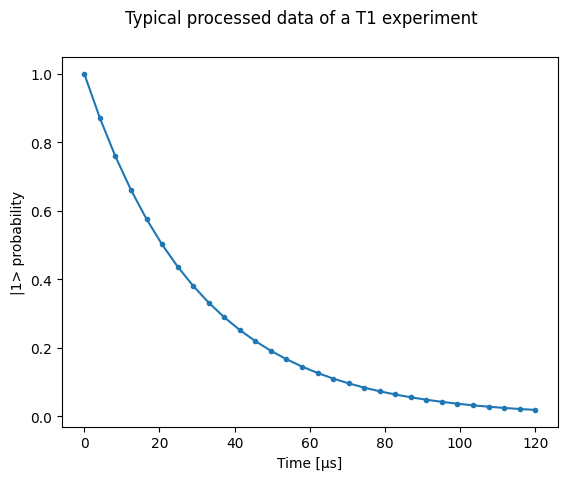

In [12]:
# parameters of our qubit model
tau = 30e-6
ground = -0.2 + 0.65j  # ground state on the IQ-plane
excited = 0.7 - 0.4j  # excited state on the IQ-plane
centers = ground, excited
sigmas = [0.1] * 2  # sigma, NB in general not the same for both state

# mock of data acquisition configuration
# NB usually at least 1000+ shots are taken, here we use less for faster code execution
num_shots = 256
# time delays between exciting the qubit and measuring its state
t1_times = np.linspace(0, 120e-6, 30)

# NB this are the ideal probabilities from repeating the measurement many times for a
# qubit with a lifetime given by tau
probabilities = exp_decay_func(t=t1_times, tau=tau, offset=0, n_factor=1, amplitude=1)

# Ideal experiment result
plt.ylabel("|1> probability")
plt.suptitle("Typical processed data of a T1 experiment")
plt.plot(t1_times * 1e6, probabilities, ".-")
_ = plt.xlabel("Time [µs]")

In [13]:
# convenience dict with the mock parameters
mock_conf = dict(
    num_shots=num_shots,
    centers=centers,
    sigmas=sigmas,
    t1_times=t1_times,
    probabilities=probabilities,
)

### T1 experiment averaged

In this first example, we generate the individual measurement shots and average them,
similar to what some instruments are capable of doing directly in the hardware.

Here is how we store this data in the dataset along with the coordinates of these
datapoints:

In [14]:
display_source_code(dataset_examples.mk_t1_av_dataset)

def mk_t1_av_dataset(
    t1_times: Optional[np.ndarray] = None,
    probabilities: Optional[np.ndarray] = None,
    **kwargs,
) -> xr.Dataset:
    """
    Generates a dataset with mock data of a T1 experiment for a single qubit.

    Parameters
    ----------
    t1_times
        Array with the T1 times corresponding to each probability in ``probabilities``.
    probabilities
        The probabilities of finding the qubit in the excited state.
    **kwargs
        Keyword arguments passed to
        :func:`~quantify_core.utilities.examples_support.mk_iq_shots`.
    """
    if t1_times is None:
        t1_times = np.linspace(0, 120e-6, 30)

    if probabilities is None:
        probabilities = exp_decay_func(
            t=t1_times, tau=50e-6, offset=0, n_factor=1, amplitude=1
        )

    q0_iq_av = mk_shots_from_probabilities(probabilities, **kwargs).mean(axis=0)

    main_dims = ("main_dim",)
    q0_attrs = mk_main_var_attrs(unit="V", long_name="Q0 IQ amplitude")
    t1_time_attrs = mk_main_coord_attrs(unit="s", long_name="T1 Time")

    data_vars = dict(q0_iq_av=(main_dims, q0_iq_av, q0_attrs))
    coords = dict(t1_time=(main_dims, t1_times, t1_time_attrs))

    dataset = xr.Dataset(
        data_vars=data_vars,
        coords=coords,
        attrs=mk_dataset_attrs(),
    )
    return dataset

In [15]:
dataset = dataset_examples.mk_t1_av_dataset(**mock_conf)
assert dataset == round_trip_dataset(dataset)  # confirm read/write

dataset

<xarray.Dataset> Size: 720B
Dimensions:   (main_dim: 30)
Coordinates:
    t1_time   (main_dim) float64 240B 0.0 4.138e-06 ... 0.0001159 0.00012
Dimensions without coordinates: main_dim
Data variables:
    q0_iq_av  (main_dim) complex128 480B (-0.19894114958423859+0.651550013884...
Attributes:
    tuid:                      20241014-175525-933-868d09
    dataset_name:              
    dataset_state:             None
    timestamp_start:           None
    timestamp_end:             None
    quantify_dataset_version:  2.0.0
    software_versions:         {}
    relationships:             []
    json_serialize_exclude:    []

In [16]:
dataset.q0_iq_av.shape, dataset.q0_iq_av.dtype

((30,), dtype('complex128'))

In [17]:
dataset_gridded = dh.to_gridded_dataset(
    dataset,
    dimension="main_dim",
    coords_names=dattrs.get_main_coords(dataset),
)
dataset_gridded

<xarray.Dataset> Size: 720B
Dimensions:   (t1_time: 30)
Coordinates:
  * t1_time   (t1_time) float64 240B 0.0 4.138e-06 ... 0.0001159 0.00012
Data variables:
    q0_iq_av  (t1_time) complex128 480B (-0.19894114958423859+0.6515500138845...
Attributes:
    tuid:                      20241014-175525-933-868d09
    dataset_name:              
    dataset_state:             None
    timestamp_start:           None
    timestamp_end:             None
    quantify_dataset_version:  2.0.0
    software_versions:         {}
    relationships:             []
    json_serialize_exclude:    []

In [18]:
display_source_code(plot_xr_complex)
display_source_code(plot_xr_complex_on_plane)

def plot_xr_complex(
    var: xr.DataArray,
    marker_scatter: str = "o",
    label_real: str = "Real",
    label_imag: str = "Imag",
    cmap: str = "viridis",
    c: np.ndarray | None = None,
    kwargs_line: dict | None = None,
    kwargs_scatter: dict | None = None,
    title: str = "{} [{}]; shape = {}",
    legend: bool = True,
    ax: object = None,
) -> tuple[Figure, Axes]:
    """Plots the real and imaginary parts of complex data. Points are colored by default
    according to their order in the array.

    Parameters
    ----------
    var
        1D array of complex data.
    marker_scatter
        Marker used for the scatter plot.
    label_real
        Label for legend.
    label_imag
        Label for legend.
    cmap
        The colormap to use for coloring the points.
    c
        Color of the points. Defaults to an array of integers.
    kwargs_line
        Keyword arguments passed to :meth:`matplotlib.axes.Axes.plot`.
    kwargs_scatter
        Keyword arguments passed to :meth:`matplotlib.axes.Axes.scatter`.
    title
        Axes title. By default gets formatted with ``var.long_name``, ``var.name`` and
        var.shape``.
    legend
        Calls :meth:`~matplotlib.axes.Axes.legend` if ``True``.
    ax
        The matplotlib axes. If ``None`` a new axes (and figure) is created.
    """

    if ax is None:
        _, ax = plt.subplots()

    if c is None:
        c = np.arange(len(var))

    if kwargs_line is None:
        kwargs_line = {}

    if kwargs_scatter is None:
        kwargs_scatter = {}

    if "marker" not in kwargs_line:
        kwargs_line["marker"] = ""

    var.real.plot(ax=ax, label=label_real, **kwargs_line)
    var.imag.plot(ax=ax, label=label_imag, **kwargs_line)

    for vals in (var.real, var.imag):
        ax.scatter(
            next(iter(var.coords.values())).values,
            vals,
            marker=marker_scatter,
            c=c,
            cmap=cmap,
            **kwargs_scatter,
        )

    ax.set_title(title.format(var.long_name, var.name, var.shape))

    if legend:
        ax.legend()

    return ax.get_figure(), ax

def plot_xr_complex_on_plane(
    var: xr.DataArray,
    marker: str = "o",
    label: str = "Data on imaginary plane",
    cmap: str = "viridis",
    c: np.ndarray | None = None,
    xlabel: str = "Real{}{}{}",
    ylabel: str = "Imag{}{}{}",
    legend: bool = True,
    ax: object = None,
    **kwargs,
) -> tuple[Figure, Axes]:
    """Plots complex data on the imaginary plane. Points are colored by default
    according to their order in the array.


    Parameters
    ----------
    var
        1D array of complex data.
    marker
        Marker used for the scatter plot.
    label
        Data label for the legend.
    cmap
        The colormap to use for coloring the points.
    c
        Color of the points. Defaults to an array of integers.
    xlabel
        Label o x axes.
    ylabel
        Label o y axes.
    legend
        Calls :meth:`~matplotlib.axes.Axes.legend` if ``True``.
    ax
        The matplotlib axes. If ``None`` a new axes (and figure) is created.
    """

    if ax is None:
        _, ax = plt.subplots()

    if c is None:
        c = np.arange(0, len(var))

    ax.scatter(var.real, var.imag, marker=marker, label=label, c=c, cmap=cmap, **kwargs)

    unit_str = get_unit_from_attrs(var)
    ax.set_xlabel(xlabel.format(" ", var.name, unit_str))
    ax.set_ylabel(ylabel.format(" ", var.name, unit_str))

    if legend:
        ax.legend()

    return ax.get_figure(), ax

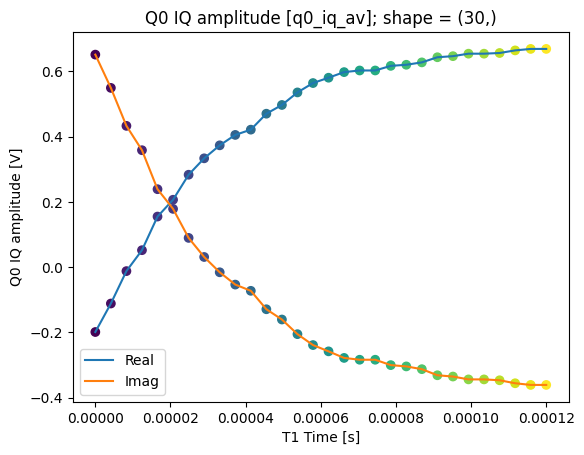

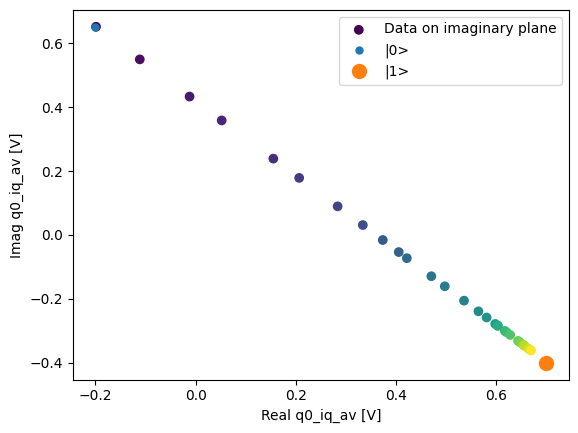

In [19]:
plot_xr_complex(dataset_gridded.q0_iq_av)
fig, ax = plot_xr_complex_on_plane(dataset_gridded.q0_iq_av)
_ = plot_complex_points(centers, ax=ax)

### T1 experiment averaged with calibration points

It is common for many experiments to require calibration data in order to interpret the
results. Often, these calibration data points have different array shapes. E.g. it can be
just two simple data points corresponding to the ground and excited states of our
transmon.

To accommodate this data in the dataset we make use of a secondary dimension along which
the variables and its coordinate will lie along.

Additionally, since the secondary variable and coordinate used for calibration can have
arbitrary names and relate to other variables in more complex ways, we specify this
relationship in the dataset attributes
(see {class}`~quantify_core.data.dataset_attrs.QDatasetIntraRelationship`).
This information can be used later, for example, to run an appropriate analysis on this
dataset.

In [20]:
display_source_code(dataset_examples.mk_t1_av_with_cal_dataset)

def mk_t1_av_with_cal_dataset(
    t1_times: Optional[np.ndarray] = None,
    probabilities: Optional[np.ndarray] = None,
    **kwargs,
) -> xr.Dataset:
    """
    Generates a dataset with mock data of a T1 experiment for a single qubit including
    calibration points for the ground and excited states.

    Parameters
    ----------
    t1_times
        Array with the T1 times corresponding to each probability in ``probabilities``.
    probabilities
        The probabilities of finding the qubit in the excited state.
    **kwargs
        Keyword arguments passed to
        :func:`~quantify_core.utilities.examples_support.mk_iq_shots`.
    """
    # reuse previous dataset
    dataset_av = mk_t1_av_dataset(t1_times, probabilities, **kwargs)

    # generate mock calibration data for the ground and excited states
    q0_iq_av_cal = mk_shots_from_probabilities([0, 1], **kwargs).mean(axis=0)

    secondary_dims = ("cal_dim",)
    q0_cal_attrs = mk_secondary_var_attrs(unit="V", long_name="Q0 IQ Calibration")
    cal_attrs = mk_secondary_coord_attrs(unit="", long_name="Q0 state")

    relationships = [
        dattrs.QDatasetIntraRelationship(
            item_name=dataset_av.q0_iq_av.name,  # name of a variable in the dataset
            relation_type="calibration",
            related_names=["q0_iq_av_cal"],  # the secondary variable in the dataset
        ).to_dict()
    ]

    data_vars = dict(
        q0_iq_av=dataset_av.q0_iq_av,  # reuse from the other dataset
        q0_iq_av_cal=(secondary_dims, q0_iq_av_cal, q0_cal_attrs),
    )
    coords = dict(
        t1_time=dataset_av.t1_time,  # reuse from the other dataset
        cal=(secondary_dims, ["|0>", "|1>"], cal_attrs),  # coords can be strings
    )

    dataset = xr.Dataset(
        data_vars=data_vars,
        coords=coords,
        attrs=mk_dataset_attrs(relationships=relationships),  # relationships added here
    )

    return dataset

In [21]:
dataset = dataset_examples.mk_t1_av_with_cal_dataset(**mock_conf)
assert dataset == round_trip_dataset(dataset)  # confirm read/write

dataset

<xarray.Dataset> Size: 776B
Dimensions:       (main_dim: 30, cal_dim: 2)
Coordinates:
    t1_time       (main_dim) float64 240B 0.0 4.138e-06 ... 0.0001159 0.00012
    cal           (cal_dim) <U3 24B '|0>' '|1>'
Dimensions without coordinates: main_dim, cal_dim
Data variables:
    q0_iq_av      (main_dim) complex128 480B (-0.19894114958423859+0.65155001...
    q0_iq_av_cal  (cal_dim) complex128 32B (0.7010588504157614-0.398449986115...
Attributes:
    tuid:                      20241014-175526-412-cfb519
    dataset_name:              
    dataset_state:             None
    timestamp_start:           None
    timestamp_end:             None
    quantify_dataset_version:  2.0.0
    software_versions:         {}
    relationships:             [{'item_name': 'q0_iq_av', 'relation_type': 'c...
    json_serialize_exclude:    []

In [22]:
dattrs.get_main_dims(dataset), dattrs.get_secondary_dims(dataset)

(['main_dim'], ['cal_dim'])

In [23]:
dataset.relationships


[
    {
        'item_name': 'q0_iq_av',
        'relation_type': 'calibration',
        'related_names': ['q0_iq_av_cal'],
        'relation_metadata': {}
    }
]

As before the coordinates can be set to index the variables that lie along the same
dimensions:

In [24]:
dataset_gridded = dh.to_gridded_dataset(
    dataset,
    dimension="main_dim",
    coords_names=dattrs.get_main_coords(dataset),
)
dataset_gridded = dh.to_gridded_dataset(
    dataset_gridded,
    dimension="cal_dim",
    coords_names=dattrs.get_secondary_coords(dataset_gridded),
)
dataset_gridded

<xarray.Dataset> Size: 776B
Dimensions:       (t1_time: 30, cal: 2)
Coordinates:
  * t1_time       (t1_time) float64 240B 0.0 4.138e-06 ... 0.0001159 0.00012
  * cal           (cal) <U3 24B '|0>' '|1>'
Data variables:
    q0_iq_av      (t1_time) complex128 480B (-0.19894114958423859+0.651550013...
    q0_iq_av_cal  (cal) complex128 32B (0.7010588504157614-0.3984499861154196...
Attributes:
    tuid:                      20241014-175526-412-cfb519
    dataset_name:              
    dataset_state:             None
    timestamp_start:           None
    timestamp_end:             None
    quantify_dataset_version:  2.0.0
    software_versions:         {}
    relationships:             [{'item_name': 'q0_iq_av', 'relation_type': 'c...
    json_serialize_exclude:    []

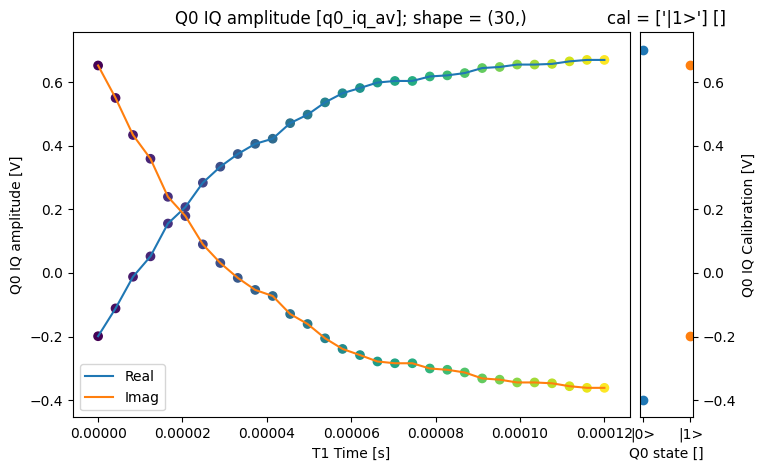

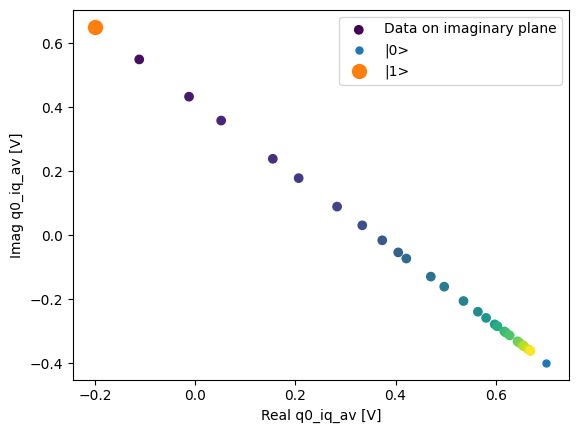

In [25]:
fig = plt.figure(figsize=(8, 5))

ax = plt.subplot2grid((1, 10), (0, 0), colspan=9, fig=fig)
plot_xr_complex(dataset_gridded.q0_iq_av, ax=ax)

ax_calib = plt.subplot2grid((1, 10), (0, 9), colspan=1, fig=fig, sharey=ax)
for i, color in zip(
    range(2), ["C0", "C1"]
):  # plot each calibration point with same color
    dataset_gridded.q0_iq_av_cal.real[i : i + 1].plot.line(
        marker="o", ax=ax_calib, linestyle="", color=color
    )
    dataset_gridded.q0_iq_av_cal.imag[i : i + 1].plot.line(
        marker="o", ax=ax_calib, linestyle="", color=color
    )
ax_calib.yaxis.set_label_position("right")
ax_calib.yaxis.tick_right()

fig, ax = plot_xr_complex_on_plane(dataset_gridded.q0_iq_av)
_ = plot_complex_points(dataset_gridded.q0_iq_av_cal.values, ax=ax)

We can use the calibration points to normalize the data and obtain the typical T1 decay.

### Data rotation and normalization utilities

The normalization of the calibration points can be achieved as follows.
Several of the
{mod}`single-qubit time-domain analyses <quantify_core.analysis.single_qubit_timedomain>`
provided use this under the hood.
The result is that most of the information will now be contained within the same
quadrature.

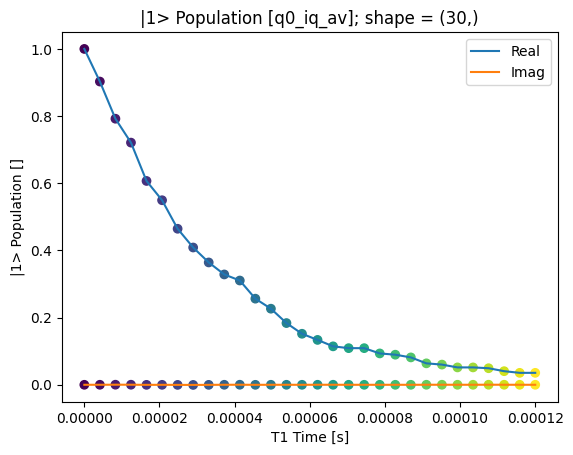

In [26]:
rotated_and_normalized = rotate_to_calibrated_axis(
    dataset_gridded.q0_iq_av.values, *dataset_gridded.q0_iq_av_cal.values
)
rotated_and_normalized_da = xr.DataArray(dataset_gridded.q0_iq_av)
rotated_and_normalized_da.values = rotated_and_normalized
rotated_and_normalized_da.attrs["long_name"] = "|1> Population"
rotated_and_normalized_da.attrs["units"] = ""
_ = plot_xr_complex(rotated_and_normalized_da)

### T1 experiment storing all shots

Now we will include in the dataset all the single qubit states (shot) for each
individual measurement.

In [27]:
display_source_code(dataset_examples.mk_t1_shots_dataset)

def mk_t1_shots_dataset(
    t1_times: Optional[np.ndarray] = None,
    probabilities: Optional[np.ndarray] = None,
    **kwargs,
) -> xr.Dataset:
    """
    Generates a dataset with mock data of a T1 experiment for a single qubit including
    calibration points for the ground and excited states, including all the individual
    shots (repeated qubit state measurement for the same exact experiment).

    Parameters
    ----------
    t1_times
        Array with the T1 times corresponding to each probability in ``probabilities``.
    probabilities
        The probabilities of finding the qubit in the excited state.
    **kwargs
        Keyword arguments passed to
        :func:`~quantify_core.utilities.examples_support.mk_iq_shots`.
    """
    # reuse previous dataset
    dataset_av_with_cal = mk_t1_av_with_cal_dataset(t1_times, probabilities, **kwargs)
    if probabilities is None:
        probabilities = dataset_av_with_cal.q0_iq_av.values
        probabilities = rotate_to_calibrated_axis(
            probabilities, *dataset_av_with_cal.q0_iq_av_cal.values
        ).real
    # generate mock data containing all the shots,
    # NB not the same data that was used for the average above, but this is just a mock
    q0_iq_shots = mk_shots_from_probabilities(probabilities, **kwargs)
    q0_iq_shots_cal = mk_shots_from_probabilities([0, 1], **kwargs)

    # the xarray dimensions will now require an outer repetitions dimension
    secondary_dims_rep = ("repetitions", "cal_dim")
    main_dims_rep = ("repetitions", "main_dim")

    relationships = [
        dattrs.QDatasetIntraRelationship(
            item_name=dataset_av_with_cal.q0_iq_av.name,
            relation_type="calibration",
            related_names=[dataset_av_with_cal.q0_iq_av_cal.name],
        ).to_dict(),
        dattrs.QDatasetIntraRelationship(
            item_name="q0_iq_shots",
            relation_type="calibration",
            related_names=["q0_iq_cal_shots"],
        ).to_dict(),
        # suggestion of a custom relationship
        dattrs.QDatasetIntraRelationship(
            item_name=dataset_av_with_cal.q0_iq_av.name,
            relation_type="individual_shots",
            related_names=["q0_iq_shots"],
        ).to_dict(),
    ]

    # Flag that these variables use a repetitions dimension
    q0_attrs_rep = dict(dataset_av_with_cal.q0_iq_av.attrs)
    q0_attrs_rep["has_repetitions"] = True
    q0_cal_attrs_rep = dict(dataset_av_with_cal.q0_iq_av_cal.attrs)
    q0_cal_attrs_rep["has_repetitions"] = True

    data_vars = dict(
        # variables that are the same as in the previous dataset, and are now redundant,
        # however, we include them to showcase the dataset flexibility
        q0_iq_av=dataset_av_with_cal.q0_iq_av,
        q0_iq_av_cal=dataset_av_with_cal.q0_iq_av_cal,
        # variables that contain all the individual shots
        q0_iq_shots=(main_dims_rep, q0_iq_shots, q0_attrs_rep),
        q0_iq_shots_cal=(secondary_dims_rep, q0_iq_shots_cal, q0_cal_attrs_rep),
    )

    dataset = xr.Dataset(
        data_vars=data_vars,
        coords=dataset_av_with_cal.coords,  # same coordinates as in previous dataset
        attrs=mk_dataset_attrs(relationships=relationships),  # relationships added here
    )

    return dataset

In [28]:
dataset = dataset_examples.mk_t1_shots_dataset(**mock_conf)
dataset

<xarray.Dataset> Size: 132kB
Dimensions:          (main_dim: 30, cal_dim: 2, repetitions: 256)
Coordinates:
    t1_time          (main_dim) float64 240B 0.0 4.138e-06 ... 0.0001159 0.00012
    cal              (cal_dim) <U3 24B '|0>' '|1>'
Dimensions without coordinates: main_dim, cal_dim, repetitions
Data variables:
    q0_iq_av         (main_dim) complex128 480B (-0.19894114958423859+0.65155...
    q0_iq_av_cal     (cal_dim) complex128 32B (0.7010588504157614-0.398449986...
    q0_iq_shots      (repetitions, main_dim) complex128 123kB (-0.28983654535...
    q0_iq_shots_cal  (repetitions, cal_dim) complex128 8kB (0.610163454644259...
Attributes:
    tuid:                      20241014-175527-167-9f5631
    dataset_name:              
    dataset_state:             None
    timestamp_start:           None
    timestamp_end:             None
    quantify_dataset_version:  2.0.0
    software_versions:         {}
    relationships:             [{'item_name': 'q0_iq_av', 'relation_type': 'c...
    json_serialize_exclude:    []

In [29]:
dataset_gridded = dh.to_gridded_dataset(
    dataset,
    dimension="main_dim",
    coords_names=dattrs.get_main_coords(dataset),
)
dataset_gridded = dh.to_gridded_dataset(
    dataset_gridded,
    dimension="cal_dim",
    coords_names=dattrs.get_secondary_coords(dataset_gridded),
)
dataset_gridded

<xarray.Dataset> Size: 132kB
Dimensions:          (t1_time: 30, cal: 2, repetitions: 256)
Coordinates:
  * t1_time          (t1_time) float64 240B 0.0 4.138e-06 ... 0.0001159 0.00012
  * cal              (cal) <U3 24B '|0>' '|1>'
Dimensions without coordinates: repetitions
Data variables:
    q0_iq_av         (t1_time) complex128 480B (-0.19894114958423859+0.651550...
    q0_iq_av_cal     (cal) complex128 32B (0.7010588504157614-0.3984499861154...
    q0_iq_shots      (repetitions, t1_time) complex128 123kB (-0.289836545355...
    q0_iq_shots_cal  (repetitions, cal) complex128 8kB (0.610163454644259-0.4...
Attributes:
    tuid:                      20241014-175527-167-9f5631
    dataset_name:              
    dataset_state:             None
    timestamp_start:           None
    timestamp_end:             None
    quantify_dataset_version:  2.0.0
    software_versions:         {}
    relationships:             [{'item_name': 'q0_iq_av', 'relation_type': 'c...
    json_serialize_exclude:    []

In this dataset we have both the averaged values and all the shots. The averaged values
can be plotted in the same way as before.

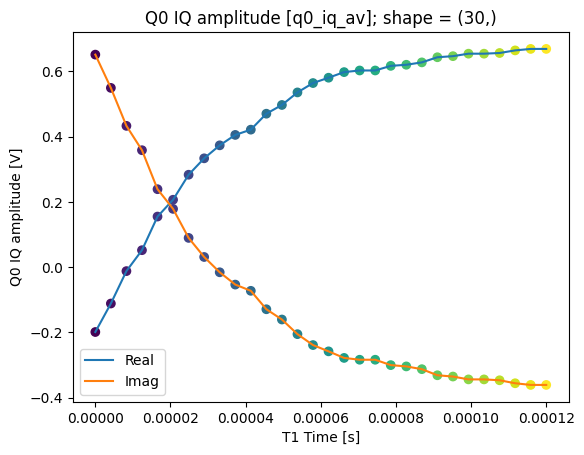

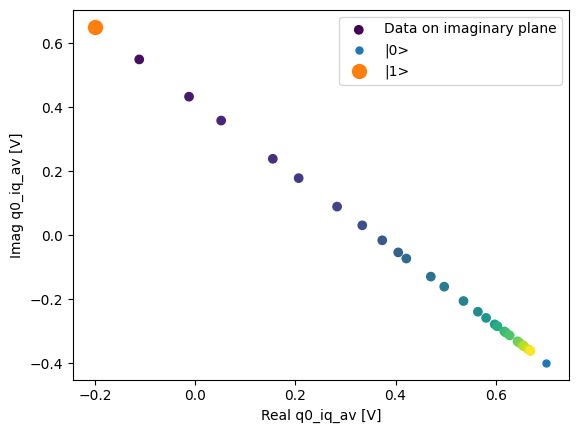

In [30]:
_ = plot_xr_complex(dataset_gridded.q0_iq_av)
_, ax = plot_xr_complex_on_plane(dataset_gridded.q0_iq_av)
_ = plot_complex_points(dataset_gridded.q0_iq_av_cal.values, ax=ax)

Here we focus on inspecting how the individual shots are distributed on the IQ plane
for some particular `Time` values.

Note that we are plotting the calibration points as well.

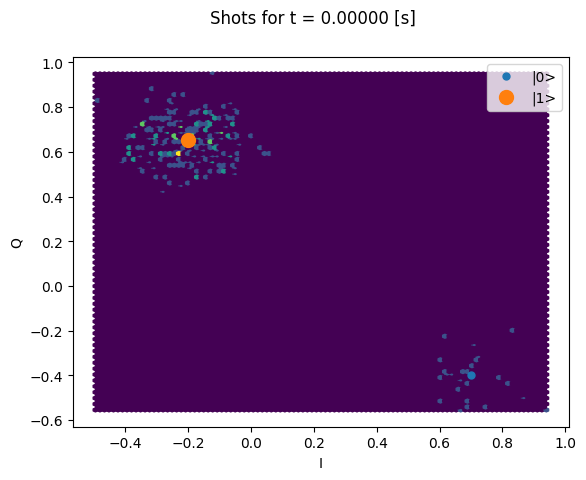

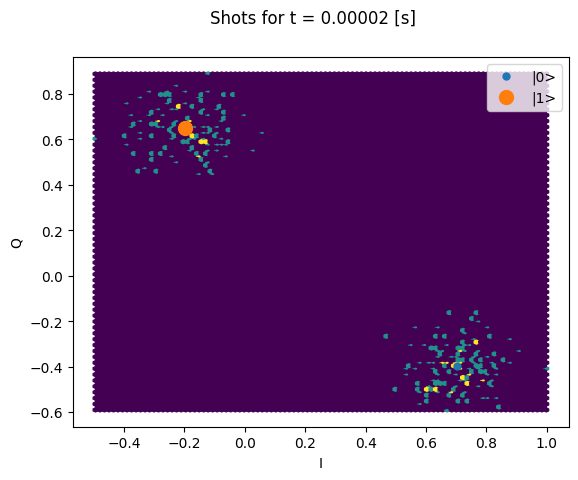

In [31]:
chosen_time_values = [
    t1_times[1],  # second value selected otherwise we won't see both centers
    t1_times[len(t1_times) // 5],  # a value close to the end of the experiment
]
for t_example in chosen_time_values:
    shots_example = (
        dataset_gridded.q0_iq_shots.real.sel(t1_time=t_example),
        dataset_gridded.q0_iq_shots.imag.sel(t1_time=t_example),
    )
    plt.hexbin(*shots_example)
    plt.xlabel("I")
    plt.ylabel("Q")
    calib_0 = dataset_gridded.q0_iq_av_cal.sel(cal="|0>")
    calib_1 = dataset_gridded.q0_iq_av_cal.sel(cal="|1>")
    plot_complex_points([calib_0, calib_1], ax=plt.gca())
    plt.suptitle(f"Shots for t = {t_example:.5f} [s]")
    plt.show()

We can collapse (average along) the `repetitions` dimension:

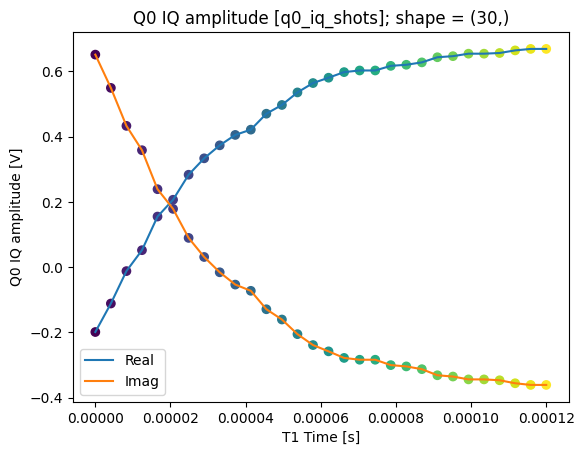

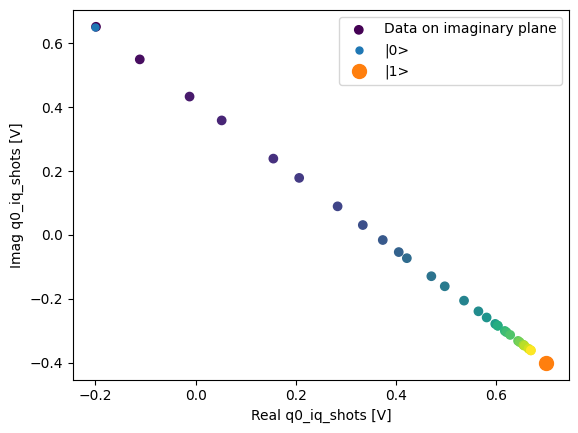

In [32]:
q0_iq_shots_mean = dataset_gridded.q0_iq_shots.mean(dim="repetitions", keep_attrs=True)
plot_xr_complex(q0_iq_shots_mean)
_, ax = plot_xr_complex_on_plane(q0_iq_shots_mean)
_ = plot_complex_points(centers, ax=ax)

(sec-dataset-t1-traces)=

### T1 experiment storing digitized signals for all shots

Finally, in addition to the individual shots we will store all the digitized readout
signals that are required to obtain the previous measurement results.

In [33]:
display_source_code(dataset_examples.mk_t1_traces_dataset)

def mk_t1_traces_dataset(
    t1_times: Optional[np.ndarray] = None,
    probabilities: Optional[np.ndarray] = None,
    **kwargs,
) -> xr.Dataset:
    """
    Generates a dataset with mock data of a T1 experiment for a single qubit including
    calibration points for the ground and excited states, including all the individual
    shots (repeated qubit state measurement for the same exact experiment); and
    including all the signals that had to be digitized to obtain the rest of the data.

    Parameters
    ----------
    t1_times
        Array with the T1 times corresponding to each probability in ``probabilities``.
    probabilities
        The probabilities of finding the qubit in the excited state.
    **kwargs
        Keyword arguments passed to
        :func:`~quantify_core.utilities.examples_support.mk_iq_shots`.
    """
    dataset_shots = mk_t1_shots_dataset(t1_times, probabilities, **kwargs)
    shots = dataset_shots.q0_iq_shots.values
    shots_cal = dataset_shots.q0_iq_shots_cal.values

    # generate mock traces for all shots
    q0_traces = np.array(tuple(map(mk_trace_for_iq_shot, shots.flatten())))
    q0_traces = q0_traces.reshape(*shots.shape, q0_traces.shape[-1])
    # generate mock traces for calibration points shots
    q0_traces_cal = np.array(tuple(map(mk_trace_for_iq_shot, shots_cal.flatten())))
    q0_traces_cal = q0_traces_cal.reshape(*shots_cal.shape, q0_traces_cal.shape[-1])

    traces_dims = ("repetitions", "main_dim", "trace_dim")
    traces_cal_dims = ("repetitions", "cal_dim", "trace_dim")
    trace_times = mk_trace_time()
    trace_attrs = mk_main_coord_attrs(long_name="Trace time", unit="s")

    relationships_with_traces = dataset_shots.relationships + [
        dattrs.QDatasetIntraRelationship(
            item_name="q0_traces",
            related_names=["q0_traces_cal"],
            relation_type="calibration",
        ).to_dict(),
    ]

    data_vars = dict(
        q0_iq_av=dataset_shots.q0_iq_av,
        q0_iq_av_cal=dataset_shots.q0_iq_av_cal,
        q0_iq_shots=dataset_shots.q0_iq_shots,
        q0_iq_shots_cal=dataset_shots.q0_iq_shots_cal,
        q0_traces=(traces_dims, q0_traces, dataset_shots.q0_iq_shots.attrs),
        q0_traces_cal=(
            traces_cal_dims,
            q0_traces_cal,
            dataset_shots.q0_iq_shots_cal.attrs,
        ),
    )
    coords = dict(
        t1_time=dataset_shots.t1_time,
        cal=dataset_shots.cal,
        trace_time=(("trace_dim",), trace_times, trace_attrs),
    )

    dataset = xr.Dataset(
        data_vars=data_vars,
        coords=coords,
        attrs=mk_dataset_attrs(relationships=relationships_with_traces),
    )

    return dataset

In [34]:
dataset = dataset_examples.mk_t1_traces_dataset(**mock_conf)
assert dataset == round_trip_dataset(dataset)  # confirm read/write

dataset

<xarray.Dataset> Size: 39MB
Dimensions:          (main_dim: 30, cal_dim: 2, repetitions: 256, trace_dim: 300)
Coordinates:
    t1_time          (main_dim) float64 240B 0.0 4.138e-06 ... 0.0001159 0.00012
    cal              (cal_dim) <U3 24B '|0>' '|1>'
    trace_time       (trace_dim) float64 2kB 0.0 1e-09 ... 2.98e-07 2.99e-07
Dimensions without coordinates: main_dim, cal_dim, repetitions, trace_dim
Data variables:
    q0_iq_av         (main_dim) complex128 480B (-0.19894114958423859+0.65155...
    q0_iq_av_cal     (cal_dim) complex128 32B (0.7010588504157614-0.398449986...
    q0_iq_shots      (repetitions, main_dim) complex128 123kB (-0.28983654535...
    q0_iq_shots_cal  (repetitions, cal_dim) complex128 8kB (0.610163454644259...
    q0_traces        (repetitions, main_dim, trace_dim) complex128 37MB (-0.2...
    q0_traces_cal    (repetitions, cal_dim, trace_dim) complex128 2MB (0.6101...
Attributes:
    tuid:                      20241014-175528-620-90d1b6
    dataset_name:              
    dataset_state:             None
    timestamp_start:           None
    timestamp_end:             None
    quantify_dataset_version:  2.0.0
    software_versions:         {}
    relationships:             [{'item_name': 'q0_iq_av', 'relation_type': 'c...
    json_serialize_exclude:    []

In [35]:
dataset.q0_traces.shape, dataset.q0_traces_cal.shape

((256, 30, 300), (256, 2, 300))

In [36]:
dataset_gridded = dh.to_gridded_dataset(
    dataset,
    dimension="main_dim",
    coords_names=["t1_time"],
)
dataset_gridded = dh.to_gridded_dataset(
    dataset_gridded,
    dimension="cal_dim",
    coords_names=["cal"],
)
dataset_gridded = dh.to_gridded_dataset(
    dataset_gridded, dimension="trace_dim", coords_names=["trace_time"]
)
dataset_gridded

<xarray.Dataset> Size: 39MB
Dimensions:          (t1_time: 30, cal: 2, repetitions: 256, trace_time: 300)
Coordinates:
  * t1_time          (t1_time) float64 240B 0.0 4.138e-06 ... 0.0001159 0.00012
  * cal              (cal) <U3 24B '|0>' '|1>'
  * trace_time       (trace_time) float64 2kB 0.0 1e-09 ... 2.98e-07 2.99e-07
Dimensions without coordinates: repetitions
Data variables:
    q0_iq_av         (t1_time) complex128 480B (-0.19894114958423859+0.651550...
    q0_iq_av_cal     (cal) complex128 32B (0.7010588504157614-0.3984499861154...
    q0_iq_shots      (repetitions, t1_time) complex128 123kB (-0.289836545355...
    q0_iq_shots_cal  (repetitions, cal) complex128 8kB (0.610163454644259-0.4...
    q0_traces        (repetitions, t1_time, trace_time) complex128 37MB (-0.2...
    q0_traces_cal    (repetitions, cal, trace_time) complex128 2MB (0.6101634...
Attributes:
    tuid:                      20241014-175528-620-90d1b6
    dataset_name:              
    dataset_state:             None
    timestamp_start:           None
    timestamp_end:             None
    quantify_dataset_version:  2.0.0
    software_versions:         {}
    relationships:             [{'item_name': 'q0_iq_av', 'relation_type': 'c...
    json_serialize_exclude:    []

In [37]:
dataset_gridded.q0_traces.shape, dataset_gridded.q0_traces.dims

((256, 30, 300), ('repetitions', 't1_time', 'trace_time'))

All the previous data is also present, but in this dataset we can inspect the IQ signal
for each individual shot. Let's inspect the signal of shot number 123 of the last
"point" of the T1 experiment:

In [38]:
trace_example = dataset_gridded.q0_traces.sel(
    repetitions=123, t1_time=dataset_gridded.t1_time[-1]
)
trace_example.shape, trace_example.dtype

((300,), dtype('complex128'))

Now we can plot these digitized signals for each quadrature. For clarity, we plot only
part of the signal.

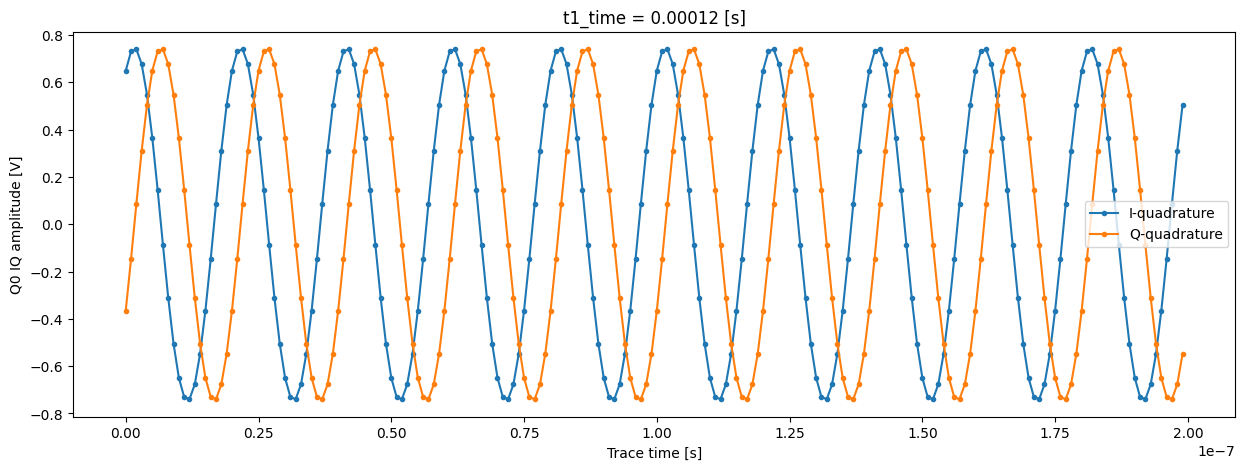

In [39]:
trace_example_plt = trace_example[:200]
trace_example_plt.real.plot(figsize=(15, 5), marker=".", label="I-quadrature")
trace_example_plt.imag.plot(marker=".", label="Q-quadrature")
plt.gca().legend()
plt.show()